# Design of an Aquaporin mimic for desalinization

The molecule below is a 35 Angstrom long bundle of three greasy spiroligomers that could be dropped into a membrane to simulate its dynamics and its ability to filter water and exclude salts.

The goal of this design is to exploit symmetry to create something that is easier to synthesize.  This structure consists of just three spiroligomers and has 3-fold symmetry.

It was built using the Cando programming language.  The Cando source file builds the three-dimensional structure from a Chemdraw structure.

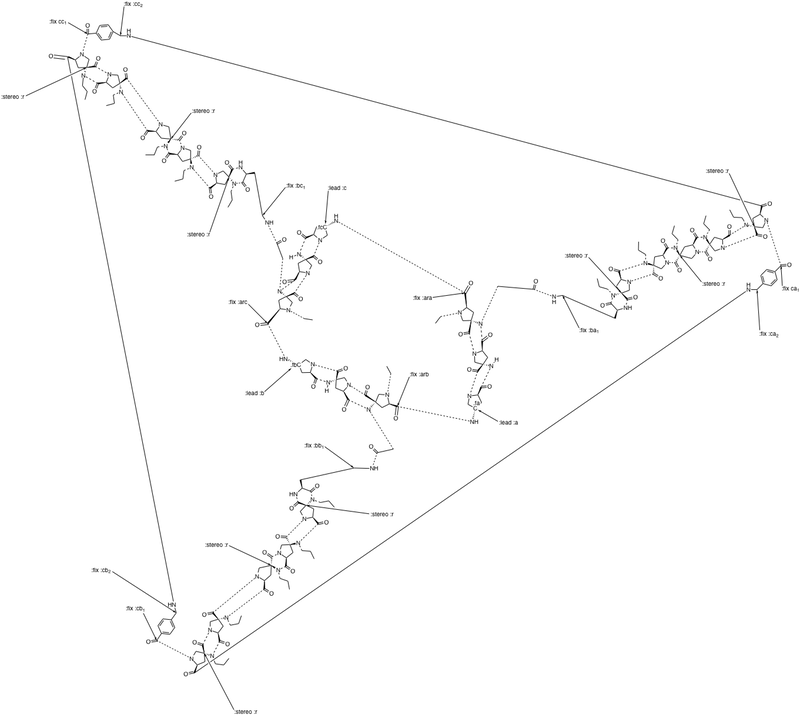

In [1]:
(png-from-file "data/aquaporin/trimemwide image.png")

In [1]:
(progn
  (defun line (x p0 p1)
    (let* ((dir (geom:sub p1 p0))
           (p (geom:add p0 (list (geom:v* dir x)))))
      p))

  (defclass unit-cell ()
    ((unit-s :initarg :unit-s :accessor unit-s)
     (unit-t :initarg :unit-t :accessor unit-t)))

  (defun radians (angle-degrees)
    (* 0.0174533 angle-degrees))
  
  (defun p3-unit-cell (dist &optional (angle-degrees 0.0) (s-dir (geom:vec 1.0 0.0 0.0)))
    (let* ((rot-cell (geom:make-m4-rotate-z (radians angle-degrees)))
           (s-scaled (geom:v* (geom:vnormalized s-dir) dist))
           (s-cell (geom:m*v rot-cell s-scaled))
           (trans (geom:make-m4-rotate-z (* -60.0 0.0174533)))
           (t-cell (geom:m*v trans s-cell)))
      (make-instance 'unit-cell :unit-s s-cell :unit-t t-cell)))

  (defun p1-unit-cell (s-cell t-cell)
      (make-instance 'unit-cell :unit-s s-cell :unit-t t-cell))

  (defun add-unit-cell (accumulate-agg original-agg unit-cell si ti)
    (let* ((vec-s (geom:v* (unit-s unit-cell) si))
           (vec-t (geom:v* (unit-t unit-cell) ti))
           (vec (geom:v+ vec-s vec-t))
           (trans (geom:make-m4-translate vec))
           (new-agg (chem:matter-copy original-agg)))
      (chem:apply-transform-to-atoms new-agg trans)
      (chem:map-molecules nil (lambda (m) (chem:add-molecule accumulate-agg m))
                          new-agg)))

  (defparameter *positions* '(
                              ( 0 0 )
                              ( 1 0 )
                              ( 0 1 )
                              ( 1 1 )
                              ( 2 0 )
                              ( 2 1 )
                              ( -1 2 )
                              ( 1 2 )
                              ( 0 2 )
                              ( -1 3 )
                              ( 0 3 )
                              ( 1 3 )
                              ))

  (defun build-cell (orig-agg unit-cell &optional (positions *positions*))
    (let ((agg (chem:make-aggregate)))
      (dolist (pos positions)
        (let ((ps (first pos))
              (pt (second pos)))
          (add-unit-cell agg orig-agg unit-cell ps pt)))
      agg))

  (defun energy-for-agg (agg)
    (let ((ef (chem:make-energy-function agg *ff*)))
      (chem:calculate-energy ef)))

  (defun quick-minimize (energy-func)
    (let ((minimizer (chem:make-minimizer :energy-function energy-func))
          (restraint-term (chem:get-anchor-restraint-component energy-func)))
      (chem:disable restraint-term)
      (cando:configure-minimizer minimizer
                                 :max-steepest-descent-steps 5
                                 :max-conjugate-gradient-steps 5
                                 :max-truncated-newton-steps 0)
      (chem:enable-print-intermediate-results minimizer)
      #+(or)(chem:set-option energy-func 'chem:nonbond-term nil)
      #+(or)(cando:minimize-no-fail minimizer)
      (chem:set-option energy-func 'chem:nonbond-term t)
      (cando:minimize-no-fail minimizer)))

  (defun check-interactions (agg)
    (let ((energy-function (chem:make-energy-function agg *ff*)))
      (chem:check-for-beyond-threshold-interactions energy-function)))
  
  (defun sample (agg)
    (let ((energy-function (chem:make-energy-function agg *ff*)))
      (quick-minimize energy-function)
      (values (chem:calculate-energy energy-function) (chem:check-for-beyond-threshold-interactions energy-function))))
  
  (defun search-p3-dist (orig-agg &key dist-start dist-end (dist-inc 2.0)
                                    rot-start rot-end (rot-inc (* 20.0 0.0174533)))
    (let (results)
      (loop for dist from dist-start to dist-end by dist-inc
         do (loop for rot from rot-start to rot-end by rot-inc
               for unit-cell = (p3-unit-cell dist rot)
               for agg = (build-cell orig-agg unit-cell *positions*)
               do (progn
                    (format t "Searching distance: ~a rotation: ~a~%" dist rot)
                    (multiple-value-bind  (energy beyond-threshold)
                        (sample agg)
                      (push (list energy beyond-threshold dist rot) results)
                      (format t "ENERGY: ~a beyond-threshold: ~a  @ distance: ~a rotation: ~a~%"
                              energy beyond-threshold dist rot )))))
      results))
  ;; More functions here?
  )

SEARCH-P3-DIST

In [2]:
(progn
  (defparameter *cd*
    (with-open-file
        (fin (probe-file "data/aquaporin/trimemwide.cdxml") :direction :input)
      (chem:make-chem-draw fin)))
  (defparameter *agg* (chem:as-aggregate *cd*)))


*AGG*

In [ ]:
(progn
  (defparameter *stereocenters*
    (sort (cando:gather-stereocenters *agg*) #'string< :key #'chem:get-name))
  (cando:set-stereoisomer-func *stereocenters* (constantly :S) :show t)
  (cando:set-stereoisomer-func (select:atoms-with-property *agg* :lead) (constantly :R) :show t)
  (dolist (a (select:atoms-with-property *agg* :stereo))
    (chem:set-configuration a (getf (chem:properties a) :stereo))
    (format t "Set ~a to ~a~%" (chem:get-name a) (chem:get-configuration a))))

In [ ]:
;;; ------ Restrain a few atoms in space -------
(defparameter *fix-atoms*
  (sort (select:atoms-with-property *agg* :fix) #'string<
        :key (lambda (a) (string (getf (chem:properties a) :fix)))))

In [ ]:
;;; ------ Print some atom properties
(dolist (a *fix-atoms*)
  (format t "properties: ~a~%" (chem:properties a)))

In [ ]:
(let ((macrocycle-points (anchor:circle-points 10 3 :z 20))
      (top-trifold-points (anchor:circle-points 6 3  :z 15))
      (bottom-trifold-points (anchor:circle-points 10 6 :z -20)))
  (defparameter *points* (append macrocycle-points
                                 top-trifold-points
                                 bottom-trifold-points))
;;; anchor the :fix atoms to *fixed-points*
  (anchor:on-points *fix-atoms* *points*))

In [ ]:
(leap::setup-gaff)
(cando:jostle *agg* 40)
(energy:minimize *agg*)
(energy:minimize *agg* :restraints-on nil)

#### The energy minimization above will take a while.

In [8]:
(nglv:show-aggregate *agg*)

A Jupyter Widget

In [12]:
;;; Save the structure for later
(save-mol2 *agg* "data/aquaporin/built.mol2")

Saving matter to /home/app/demos/data/aquaporin/built-safe.mol2


NIL

# Jump to here in demo if time is too short to run the minimization.

In [13]:
(:= *agg* (cando:load-mol2 "data/aquaporin/built-safe.mol2"))

*AGG*

In [14]:
(nglv:show-aggregate *agg*)

A Jupyter Widget

In [15]:
(progn
  (defparameter *cell-dimension* 16.5)
  (defparameter *array* (build-cell *agg* (p3-unit-cell *cell-dimension*)))
  (defparameter *ac-agg* *array*))

*AC-AGG*

In [16]:
(nglv:show-aggregate *array*)

A Jupyter Widget

In [18]:
(progn
  (defparameter *carbonyl* (core:make-cxx-object 'chem:chem-info))
  (chem:compile-smarts *carbonyl* "C1(~O2)-N")
  (defun find-amides (agg)
    (let ((num 0)
          (max-c 0.0)
          (min-o 0.0))
      (chem:map-atoms
       nil
       (lambda (a)
         (incf num)
         (let ((matchp (chem:matches *carbonyl* a)))
           (when matchp
             (let* ((match (chem:get-match *carbonyl*))
                    (atomc (chem:get-atom-with-tag match :1))
                    (atomo (chem:get-atom-with-tag match :2))
                    (chc (chem:get-charge atomc))
                    (cho (chem:get-charge atomo)))
               (format t "~a(~a) ~a(~a) ~a~%" atomc chc atomo cho (+ chc cho))))))
       agg)
      (format t "Searched ~a atoms~%" num)))
  (defun fix-carbonyls (agg)
    (chem:map-atoms
     nil
     (lambda (a)
       (let ((matchp (chem:matches *carbonyl* a)))
         (when matchp
           (let* ((match (chem:get-match *carbonyl*))
                  (atomc (chem:get-atom-with-tag match :1))
                  (atomo (chem:get-atom-with-tag match :2))
                  (chc (chem:get-charge atomc))
                  (cho (chem:get-charge atomo))
                  (new-chc 0.51)
                  (new-cho (+ (- 0.51 ) (+ chc cho))))
             (chem:set-charge atomc new-chc)
             (chem:set-charge atomo new-cho)))))
     agg))
  (defun total-charge (agg)
    (let ((total-charge 0.0))
      (chem:map-atoms
       nil
       (lambda (a)
         (setf total-charge (+ total-charge (chem:get-charge a))))
       agg)
      total-charge)))

TOTAL-CHARGE

In [19]:
(progn
  (defparameter *unit-cell* (p3-unit-cell *cell-dimension*))
  (defparameter *x-pbc* (geom:v* (unit-s *unit-cell*) 3))
  (defparameter *y-pbc* (geom:vec 0.0 (* (geom:vy (unit-t *unit-cell*)) 4) 0.0))
  (defparameter *pbc-min* (geom:vec 0.0 0.0 -40.0))
  (defparameter *pbc-max* (geom:vec (geom:vx *x-pbc*) (geom:vy *y-pbc*) 40.0))
  (format t "The pbc limits are: ~a ~a~%" *pbc-min* *pbc-max*))
;; Water box is 50x50x80

The pbc limits are: [ 0 0 -40 ] [ 49.5 -57.1577 40 ]


NIL

## There is a bug that breaks water box loading - I'll fix it and then we can continue from here.

In [21]:
(defparameter *water* (cando:load-psf-pdb "data/aquaporin/waterBox-original.psf" "data/aquaporin/waterBox-original.pdb"))

read header: "       4 !NTITLE"
read header: "   18948 !NATOM"
About to read 18948 lines
read header: "   12632 !NBOND: bonds"
read header: "    6316 !NTHETA: angles"
Expected NTHETA
read header: "       0 !NPHI: dihedrals"
Expected NPHI
read header: "       0 !NIMPHI: impropers"
Expected NIMPHI
read header: "       0 !NDON: donors"
Expected NDON
read header: "       0 !NACC: acceptors"
Expected NACC
read header: "       0 !NNB"
Expected NNB
Skipping bank of zeros
read header: "       1       0 !NGRP"
Expected NGRP NST2
read header: :EOF


1An error occurred of type: TYPE-ERROR: 
  #<TYPE-ERROR>


NIL

In [ ]:
;;; ------ Tile the water boxes ------
(defparameter *water-array*
  (build-cell *water*
              (p1-unit-cell (geom:vec 50.0 0.0 0.0)
                            (geom:vec 0.0 50.0 0.0))
              '((0 0) (0 1) (1 0) (1 1))))


In [ ]:
(defclass min-max-box ()
  ((box-min :initarg :box-min :accessor box-min)
   (box-max :initarg :box-max :accessor box-max)))

In [ ]:
;;; ---- Upper and lower boxes -----
(progn
  (defparameter *lower-box*
    (make-instance 'min-max-box
                   :box-min (geom:vec (geom:vx *pbc-min*)
                                      (geom:vy *pbc-min*)
                                      -40)
                   :box-max (geom:vec (geom:vx *pbc-max*)
                                      (geom:vy *pbc-max*)
                                      -21)))
  (defparameter *upper-box*
    (make-instance 'min-max-box
                   :box-min (geom:vec 0 0 21)
                   :box-max (geom:vec (geom:vx *pbc-max*)
                                      (geom:vy *pbc-max*)
                                      40))))

In [ ]:
;;; --- Determine if a molecule is within a box ----
(defun molecule-in-box (molecule box)
  (let ((center (chem:geometric-center molecule)))
    (and (< (geom:vx (box-min box)) (geom:vx center) (geom:vx (box-max box)))
         (< (geom:vy (box-min box)) (geom:vy center) (geom:vy (box-max box)))
         (< (geom:vz (box-min box)) (geom:vz center) (geom:vz (box-max box))))))

(defun isolate-molecules (aggregate box)
  (let ((new-agg (chem:make-aggregate)))
    (chem:map-molecules
     nil
     (lambda (m)
       (when (molecule-in-box m box)
         (chem:add-molecule new-agg m)))
     aggregate)
    new-agg))

(progn
  (defparameter *lower-water* (isolate-molecules *water-array* *lower-box*))
  (defparameter *upper-water* (isolate-molecules *water-array* *upper-box*)))

In [ ]:
(progn
  (defparameter *water-and-channels* (chem:make-aggregate))
  (defparameter *all0* (cando:merge-into-one-aggregate *ac-agg* *upper-water*))
  (defparameter *all* (cando:merge-into-one-aggregate *all0* *lower-water*)))

In [ ]:
(nglv:show-aggregate *all*)

In [ ]:
(progn
  (defparameter *types* (chem:get-types *ff*))
  (chem:assign-types *types* *all*))

In [ ]:
(cando:save-mol2 *all* #P"trimemwide-water-carbonyl.mol2" :use-sybyl-types nil)